# TASK 1 
## Using datetime and pytz to convert UNIX time in ns to UTC time and CERN time

In [41]:
from datetime import time
from datetime import date
from datetime import datetime
from datetime import timedelta
from pytz import timezone

In [42]:
#UNIX time is is measured from 00:00 January 1, 1970 in UTC time, so it is already in correct time zone
unix = datetime(1970, 1, 1)
nano = 1541962108935000000

#Converting to seconds because datetime does not have a nanoseconds argument
dateSeconds = int(float(nano)/1000000000.)
deltaT = timedelta(seconds = dateSeconds)

#Provided UNIX UTC time in datetime.datetime form
utcTime = unix+deltaT
print("The UTC time prompted: ", utcTime)

#Time zone representing CERN time which is normally GMT+1, but in this library is stored as GMT-1
cern_timezone = timezone('Etc/GMT-1')
print("The current time at CERN: ", datetime.now(tz=cern_timezone))

#The provided UNIX UTC time to CERN timezone in datetime.datetime form
cernTime = utcTime.astimezone(cern_timezone)
print("The CERN time from the prompted time: ", cernTime)

The UTC time prompted:  2018-11-11 18:48:28
The current time at CERN:  2019-03-22 19:50:38.148270+01:00
The CERN time from the prompted time:  2018-11-11 19:48:28+01:00


# Task 2
## The HDFSearch class is used to read the h5 file and pass it to a csv as done by the main

In [43]:
import h5py
import csv
import os
import numpy as np

In [44]:
class HDFSearch(object):
    
    def __init__(self, filename):
        self.f = h5py.File(filename, 'r')
        self.dataSetPaths = []
        self.otherDataTypePaths = []
        
    
    def toCSV(self):
        '''
        This function sends all datasets and corresponding information to the csv file.
        '''
        
        csv_data = self.csvData()
        with open("hdfData.csv", "w+") as csv_file:
            csvWriter = csv.writer(csv_file,delimiter=',')
            csvWriter.writerows(csv_data)
            
    def csvData(self):
        '''
        This method puts all csv data in a 2D list. Called on by toCSV().
        Odd classes are added at the end with 'not applicable' for size shape and type.
        '''
        
        csv_data = [['Group Path to Data Set', 'Size', 'Shape', 'Type']]
        for x in self.dataSetPaths:
            csv_data.append(self.sizeShapeType(x))
        for y in self.otherDataTypePaths:
            csv_data.append([y, 'not applicable', 'not applicable', 'not applicable'])
            
        return csv_data
    
    def sizeShapeType(self, path):
        '''
        This function returns a list of path, size, shape and data type for a given path name.
        If the data type cannot be read with hdf5, then an exception inserts a comment noting that.
        NOTE: This exception would have been deal with using pytables, but the instructions specified
        using hdf5.
        '''
        
        size = self.f[path].size
        shape = self.f[path].shape
        try:
            dtype = self.f[path].dtype
        except:
            dtype = 'Unable to parse data type with hdf5'
        
        return [path, size, shape, dtype]
    
    def runTime(self):
        '''
        Runs the top level groups, from a list achieved by the mainGroups() method, through caller().
        '''
        
        main_groups = self.mainGroups()
        for x in main_groups:
            run = self.caller(x)
    
    
    def caller(self, path):
        '''
        Is called by runTime. Uses levelDownGroups() to achieve a subgroups list (and attach datasets to 
        the self.dataSetPaths list) then recursively does so until done with all groups.
        '''
        
        new_paths_list = self.levelDownGroups(path)
        
        if len(new_paths_list) == 0:
            return 0
        else:
            for x in new_paths_list:
                self.caller(x)
            
    
    def levelDownGroups(self, path):
        '''
        Takes a path and determines if the path leads to a data set, group or other. 
        Returns list of subgroups if there are any and appends data set paths to self.dataSetPaths.
        '''
        
        subs = []
        
        for x in self.f[path]:
            new_path = path + '/' + x
            boo = self.addToListBool(new_path)
            
            if boo:
                self.dataSetPaths.append(new_path)
                
            elif boo == False:
                subs.append(new_path)
                
            elif boo == None:
                self.otherDataTypePaths.append(new_path)

            
        return subs
        
        
        
    def addToListBool(self, path):
        '''
        If the path leads to a data set, True is returned.
        If the path leads to a group, False is returned.
        If the path leads to neither, None is returned.
        '''
        
        if type(self.f[path]) == h5py._hl.dataset.Dataset:
            return True
        elif type(self.f[path]) == h5py._hl.group.Group:
            return False
        else:
            return None
    
    
    def mainGroups(self):
        '''
        This function takes the top level group from the h5 file and returns a list of names.
        '''
        
        groups = []
        for x in self.f:
            groups.append(x)
        
        return groups


        
        
def main():
    test = HDFSearch('1541962108935000000_167_838.h5')
    test.runTime()
    test.toCSV()

main()

# Task 3
## Converting 1D array with height and width from h5 file to saved 2D image in .png file

In [45]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [46]:
#h5 file to be accessed
f = h5py.File('1541962108935000000_167_838.h5', 'r')

#Data set path names that need to be accessed:
dset1 = '/AwakeEventData/XMPP-STREAK/StreakImage/streakImageData'
dsetheight = '/AwakeEventData/XMPP-STREAK/StreakImage/streakImageHeight'
dsetwidth = '/AwakeEventData/XMPP-STREAK/StreakImage/streakImageWidth'

#Height, width and 1D array being extracted
height = f[dsetheight][:][0]
width = f[dsetwidth][:][0]
arr_1D = np.zeros((344064,), dtype='int32')
f[dset1].read_direct(arr_1D, np.s_[0:width*height], np.s_[0:width*height])

#Using np.reshape to convert 1D array to 2D array
arr_2Dimage = np.reshape(arr_1D, (height, width))

#Filtering the image with scipy.signal.medfilt
finalImage = signal.medfilt(arr_2Dimage, 5)

Filtered Image

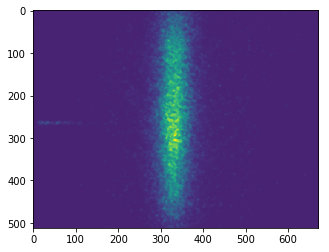

In [47]:
#Plotting the filtered image then saving as a .png file
fig = plt.figure()
plt.imshow(finalImage)
fig.savefig('filteredGSoCImage.png')

Original Image

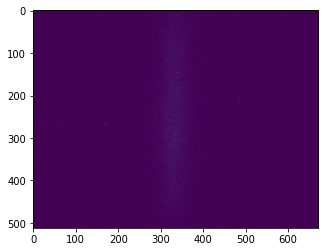

In [48]:
#Original image for comparison
plt.imshow(arr_2Dimage)